# Solution to Kaggle's Titanic problem

This is my solution to Kaggle's introductory Titanic problem. The goal is to classify Titanic's passengers as survivors or casualties.

The work is divided into two parts: This notebook consists of data preprocessing, model building and evaluation. The other one in this repository explores and visualizes the data providing a basis for the work done here.

In keeping with the problem's guidelines, I haven't used any external data. Naturally, with the list of survivors being public domain, it is possible to create a perfectly predicting model by including external data.

> _N.B.: Work in progress, so far just basic decision trees._

In [87]:
import numpy as np
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

%matplotlib inline

Import training data:

In [88]:
def import_data(filename):
    data = pd.read_csv(filename)
    return data

In [89]:
data = import_data('train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Data preprocessing

The goal is to fit a Random Forest classifier to the training data. For this, no feature scaling is required. However, the data must be in a numeric format.

* Drop `PassengerId` (used in competition submissions only).
* Represent `Sex` as a binary integer.
* Fill NaN's in `Age` with mean age.
* Transform `Embarked` to type integer.

In [90]:
def preprocess_simple(data):
    data = data.drop('PassengerId', axis=1)
    data.Sex = data.Sex.replace(['male', 'female'], [0, 1])
    data.Age = data.Age.fillna(data['Age'].mean())
    data.Embarked = data.Embarked.replace(['C', 'Q', 'S'], [0, 1, 2])
    return data

In [91]:
data = preprocess_simple(data)

### Name

`Name` values include titles. Otherwise, they are unique, so let's drop `Name` and describe it with the title and the length of the name.

In [92]:
def preprocess_names(data):
    data['Title'] = data.Name.apply(lambda x: re.search(", (.*?)\.", x).group(1))
    data['NameLength'] = data.Name.apply(len)
    data = data.drop('Name', axis=1)
    
    # Encode titles to integers by class:
    le = LabelEncoder()
    data.Title = le.fit_transform(data.Title)

    return data

In [93]:
data = preprocess_names(data)

### Ticket number

Add the "label" prefixed to some `Ticket` values as another feature to see if they hold any predictive power. Strip periods and slashes since they appear to have been used inconsistently.

In [94]:
# Helper function
def get_ticket_labels_and_numbers(ticket):
    split = ticket.split(" ")
    
    if len(split) > 1:
        label = split[0].upper()
        label = re.sub(r"[./]", "", label)
    else:
        label = ""
        
    number = split[len(split) - 1]
    
    return label, number

In [95]:
def preprocess_tickets(data):
    labels_and_numbers = pd.DataFrame(data.Ticket.apply(get_ticket_labels_and_numbers).tolist(), columns=['TicketLabel', 'TicketNo'])
    data = pd.concat([data, labels_and_numbers], axis=1)
    data = data.drop('Ticket', axis=1)
    
    ''' When converted to numeric values, the cabin numbers get quite large.
    Let's encode them to avoid any problems with float size: '''
    le = LabelEncoder()
    data.TicketNo = le.fit_transform(data.TicketNo)
    
    # Encode the ticket labels to integers by class:
    le = LabelEncoder()
    data.TicketLabel = le.fit_transform(data.TicketLabel)
    
    return data

In [96]:
data = preprocess_tickets(data)

### Cabin

Separate deck and cabin number into their own columns.

In [97]:
# Helper function
def split_cabin(cabin):
    if pd.notnull(cabin):
        match = re.search("(\w{1})(\d{1,3})", cabin)
        if match is not None:
            return match.group(1), match.group(2)
    return None, None

In [98]:
def preprocess_cabin(data):
    df = pd.DataFrame(data.Cabin.apply(split_cabin).tolist(), columns=['Deck', 'CabinNo'])
    data = pd.concat([data, df], axis=1)
    data = data.drop('Cabin', axis=1)
    
    ''' Transform deck letters into numbers. `A` was the highest deck but let's number 
    them like floors in buildings, ascending from bottom, for slightly clearer presentation. '''
    deck_letters = sorted(data.Deck[pd.notnull].unique(), reverse=True)
    deck_numbers = np.arange(1, len(deck_letters) + 1)
    data.Deck = data.Deck.replace(deck_letters, deck_numbers)
    
    return data

In [99]:
data = preprocess_cabin(data)
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,NameLength,TicketLabel,TicketNo,Deck,CabinNo
0,0,3,0,22.0,1,0,7.2500,2.0,11,23,2,161,NaN,None
1,1,1,1,38.0,1,0,71.2833,0.0,12,51,10,126,5.0,85
2,1,3,1,26.0,0,0,7.9250,2.0,8,22,25,347,NaN,None
3,1,1,1,35.0,1,0,53.1000,2.0,12,44,0,51,5.0,123
4,0,3,0,35.0,0,0,8.0500,2.0,11,24,0,606,NaN,None


### Missing data

The data still has a lot of missing values:

In [100]:
# Helper function
def missing_samples_formatted(data):
    all_rows = len(data)
    full_rows = len(data.dropna())
    print("{:.0f}% ({}/{}) of samples have no missing values".format(100 * full_rows / all_rows, full_rows, all_rows))
    
missing_samples_formatted(data)

22% (198/891) of samples have no missing values


Find the columns that have missing values and examine:

In [101]:
data.columns[data.isnull().any()].tolist()

['Embarked', 'Deck', 'CabinNo']

In [102]:
data.Embarked[pd.isnull]

61    NaN
829   NaN
Name: Embarked, dtype: float64

Since the original `Embarked` values were encoded to integers `[0, 1, 2]`, let's use `3` to designate a missing value here and `0` in `Deck` and `CabinNo`. Test set (for competition predictions) additionally has one NaN in `Fare`, use average for that.

In [103]:
def fill_missing_data(data):
    data.Embarked = data.Embarked.fillna(3)
    columns = ['Deck', 'CabinNo']
    data[columns] = data[columns].fillna(0)
    data['Fare'] = data.Fare.fillna(data.Fare.mean())
    
    return data

In [104]:
data = fill_missing_data(data)
missing_samples_formatted(data)

100% (891/891) of samples have no missing values


In [105]:
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,NameLength,TicketLabel,TicketNo,Deck,CabinNo
0,0,3,0,22.0,1,0,7.2500,2.0,11,23,2,161,0.0,0
1,1,1,1,38.0,1,0,71.2833,0.0,12,51,10,126,5.0,85
2,1,3,1,26.0,0,0,7.9250,2.0,8,22,25,347,0.0,0
3,1,1,1,35.0,1,0,53.1000,2.0,12,44,0,51,5.0,123
4,0,3,0,35.0,0,0,8.0500,2.0,11,24,0,606,0.0,0


## Preprocessing function

Put it all together for easy use later on.

In [106]:
def preprocess_data(data):
    data = preprocess_simple(data)
    data = preprocess_names(data)
    data = preprocess_tickets(data)
    data = preprocess_cabin(data)
    data = fill_missing_data(data)
    return data

## Model training and evaluation

Train different suitable models and evaluate their performance.

### Decision trees

Train decision tree sets with incremental depths to figure out good depth (range).

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [108]:
data = import_data('train.csv')
data = preprocess_data(data)
train_data, test_data, train_target, test_target = train_test_split(data.drop(['Survived'], axis=1), data.Survived)

In [109]:
def decision_tree_scores(n_iterations):
    test_means = []
    
    for max_depth in np.arange(1, 51):
        test_scores = []
        for n in np.arange(n_iterations):
            tree = DecisionTreeClassifier(max_depth=max_depth)
            tree.fit(train_data, train_target)
            test_scores.append(tree.score(test_data, test_target))
        test_scores = pd.Series(test_scores)
        test_means.append(test_scores.mean())
    
    return pd.Series(test_means)

In [110]:
scores = decision_tree_scores(1000)

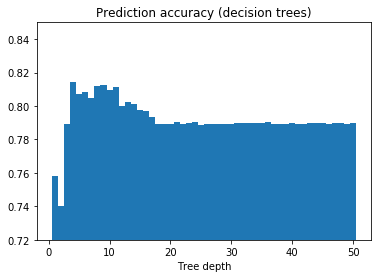

In [111]:
fig, ax = plt.subplots()
plt.bar(scores.index.values + 1, scores.values, 1)
ax.set_ylim([0.72, 0.85])
plt.title('Prediction accuracy (decision trees)')
plt.xlabel('Tree depth')
plt.show()

From the plot we see that the best accuracy is ~82% and levels off to ~77% when depth is 15 or greater.

### Random forest

Let's try random forest next to get a comparison.

In [112]:
def random_forest_scores(n_iterations):
    test_scores = []
    
    for n in np.arange(n_iterations):
        rf = RandomForestClassifier()
        rf.fit(train_data, train_target)
        test_scores.append(rf.score(test_data, test_target))
        
    return pd.Series(test_scores)

In [113]:
random_forest_scores(10000).describe()

count    10000.000000
mean         0.815960
std          0.016309
min          0.748879
25%          0.807175
50%          0.816143
75%          0.825112
max          0.874439
dtype: float64

Random forest yields an average accuracy of ~82%.

_For now, I'll just leave it at these two very basic models and move on to generating the actual competition predictions etc. to get familiar with Kaggle. To be continued..._

## Competition submission

Train the competition classifier.

In [114]:
# Use full dataset for training
data = import_data('train.csv')
data = preprocess_data(data)

rf = RandomForestClassifier()
rf.fit(data.drop(['Survived'], axis=1), data.Survived)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

Generate predictions and create CSV for submission.

In [115]:
comp_test_data = import_data('test.csv')
ids = comp_test_data.PassengerId
comp_test_data = preprocess_data(comp_test_data)

In [116]:
predictions = pd.DataFrame(rf.predict(comp_test_data), index=ids, columns=['Survived'])
predictions.to_csv('submission.csv')